In [1]:
from ml_mlp import MLP_Model
from ml_mlp import Linear_Model
from ml_mlp import MLP_Win_Model
from ml_mlp import LSTM_Model
import resources
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import multiprocessing
multiprocessing.set_start_method("spawn")

In [2]:
%matplotlib inline

# Pre-process data 
Load in feature datasets, remove wear in phase and combine.

In [3]:
exp5 = resources.load('Test 5')
exp7 = resources.load('Test 7')
exp8 = resources.load('Test 8')
exp9 = resources.load('Test 9')

In [4]:
dfs = [exp5.features.drop([23, 24]), exp7.features, exp8.features, exp9.features]
main_df = pd.concat(dfs)
main_df = main_df.drop(columns=['Runout', 'Form error', 'Peak radius', 'Radius diff'])#.drop([0, 1, 2, 3])
main_df.reset_index(drop=True, inplace=True)

In [5]:
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 708 rows x 8 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Mean radius
0,0.159501,12.643285,3.698928,-0.020471,40.801628,54.444047,19.697298,0.675643
1,1.330936,11.609588,15.609034,0.002392,44.433276,69.836889,38.384749,0.674763
2,1.999714,8.351972,19.288375,-0.039252,46.662722,74.074813,42.546872,0.674161
3,2.010478,8.404136,19.780447,-0.035595,46.317147,74.917782,42.614029,0.673917
4,2.114221,7.972116,22.575564,-0.037290,46.668332,75.681806,42.884298,0.673830


# Create Models

- MLP
- Linear
- MLP with window

In [6]:
mlp_reg = MLP_Model(feature_df=main_df,
                    target='Mean radius',
                    tb=False,
                    tb_logdir='tmux-test',
                    params={'loss': 'mse',
                            'no_layers': 3,
                            'no_nodes': 256,
                            'epochs': 100,
                            'dropout': 0.2
                                }
                   )

In [7]:
lin_reg = Linear_Model(feature_df=main_df, target='Mean radius')

In [8]:
mlp_win_reg = MLP_Win_Model(feature_df=main_df,
                            target='Mean radius',
                            tb=False,
                            tb_logdir='tmux-test',
                            params={'seq_len': 10,
                                    'loss': 'mse',
                                    'epochs': 100,
                                    'no_nodes': 256,
                                    'no_layers': 3,
                                    },
                            )

In [13]:
lstm_reg = LSTM_Model(feature_df=main_df,
                      target='Mean radius',
                      tb=False,
                      tb_logdir='tmux-test',
                      params={'seq_len': 10,
                              'loss': 'mae',
                              'epochs': 100,
                              'no_layers': 3,
                              'no_dense': 1,
                              'no_nodes': 64,
                              }
                        )

Train data shape:	(536, 10, 7)
Test data shape:	(132, 10, 7)


# Score models
## MLP:

CV Model:   0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------------
MLP-E-100-B-10-L[256 256 256]-D-0.2-20230103-142310
CV Scores:
-----------------------------------------------------------------
MAE: 6.841 (±2.037)µm
MSE: 80.529 (±39.939) µm²
R^2: 0.315 (± 0.380)
-----------------------------------------------------------------


Training:   0%|                                             0/100 ETA: ?s,  ?epochs/s

-----------------------------------------------------------------
MLP-E-100-B-10-L[256 256 256]-D-0.2-20230103-142310
Validation Scores:
-----------------------------------------------------------------
MAE = 7.330 um
MSE = 80.907 um^2
R^2 = 0.318
-----------------------------------------------------------------


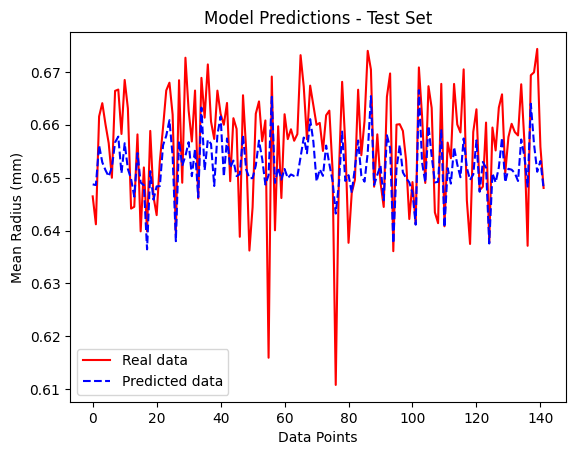

In [10]:
mlp_reg.cv(n_splits=10, n_repeats=10)
mlp_reg.fit(validation_split=0.1, verbose=0)
mlp_reg.score(plot_fig=True);


## MLP with window:

CV Model:   0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------------
MLP_Win-WLEN-10-E-100-B-10-L-[256 256 256]-D-0.1-20230103-142310
CV Scores:
-----------------------------------------------------------------
MAE: 6.178 (±2.147)µm
MSE: 69.120 (±43.297) µm²
R^2: 0.338 (± 0.381)
-----------------------------------------------------------------


Training:   0%|                                             0/100 ETA: ?s,  ?epochs/s

-----------------------------------------------------------------
MLP_Win-WLEN-10-E-100-B-10-L-[256 256 256]-D-0.1-20230103-142310
Validation Scores:
-----------------------------------------------------------------
MAE = 5.412 um
MSE = 45.056 um^2
R^2 = 0.639
-----------------------------------------------------------------


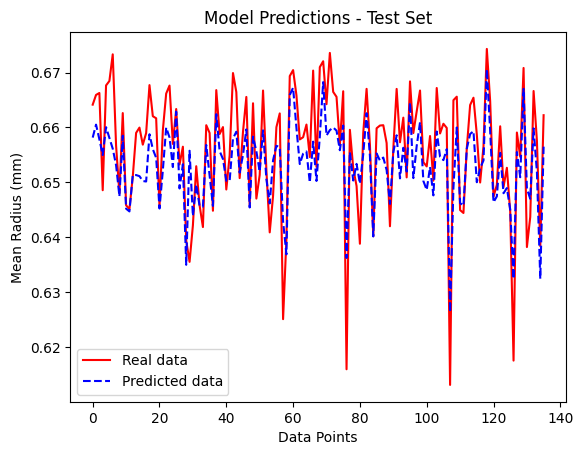

In [11]:
mlp_win_reg.cv(n_splits=10, n_repeats=10)
mlp_win_reg.fit(validation_split=0.2, verbose=0)
mlp_win_reg.score(plot_fig=True);

## LSTM:

CV Model:   0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------------
LSTM-WLEN-10-E-100-B-10-L-[64 64 64 64]-D-0.1-20230103-142801
CV Scores:
-----------------------------------------------------------------
MAE: 6.070 (±1.795)µm
MSE: 74.319 (±35.203) µm²
R^2: 0.332 (± 0.291)
-----------------------------------------------------------------


Training:   0%|                                             0/100 ETA: ?s,  ?epochs/s

-----------------------------------------------------------------
LSTM-WLEN-10-E-100-B-10-L-[64 64 64 64]-D-0.1-20230103-142801
Validation Scores:
-----------------------------------------------------------------
MAE = 5.781 um
MSE = 54.260 um^2
R^2 = 0.434
-----------------------------------------------------------------


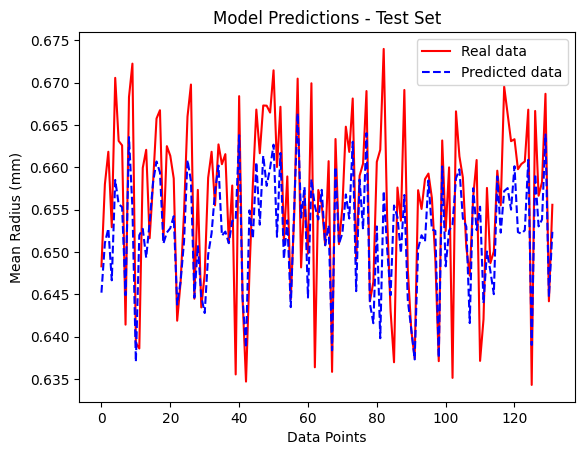

{'MAE': 0.005781411911027354,
 'MSE': 5.4259678215272744e-05,
 'r2': 0.43376334011852447}

In [14]:
    lstm_reg.cv(n_splits=10, n_repeats=10)
    lstm_reg.fit(validation_split=0.2, verbose=0)
    lstm_reg.score(plot_fig=True)

## Linear:

In [15]:
lin_reg.fit()
lin_reg.score(plot_fig=False);

-----------------------------------------------------------------
Lin_Reg-20230103-145340
Validation Scores:
-----------------------------------------------------------------
MAE =                 5.702 um
MSE =                 73.954 um^2
R^2 = 0.524
-----------------------------------------------------------------


# Visualise predictions

In [16]:
def pred_plot(y: np.ndarray, y_pred: np.ndarray, title:str = ''):
    fig, ax = plt.subplots(1, 2)
    ax[0].scatter(y, y_pred)

    # limits of max radius
    xmax = main_df['Mean radius'].values.max()
    xmin = main_df['Mean radius'].values.min()

    ax[0].set_xlim([xmin, xmax])
    ax[0].set_ylim([xmin, xmax])

    lims = [
        np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
        np.max([ax[0].get_xlim(), ax[0].get_ylim()]),
    ]

    ax[0].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax[0].set_aspect('equal')
    ax[0].set_xlabel('Actual Y / mm')
    ax[0].set_ylabel('Predicted Y /mm')
    ax[0].set_title(f'{title} - Predictions');
    
    diff = (y - y_pred)*1000

    ax[1].hist(diff, bins=30)
    ax[1].set_xlabel('Prediction Error / um')
    ax[1].set_ylabel('No Occurances')
    ax[1].set_title(f'{title} - Histogram');

    fig.tight_layout()


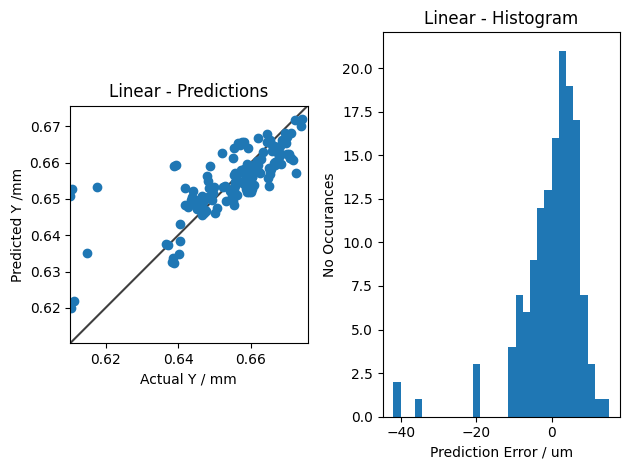

In [17]:
y = lin_reg.val_data[1].values
y_pred = lin_reg.model.predict(lin_reg.val_data[0].values)
pred_plot(y, y_pred, 'Linear')

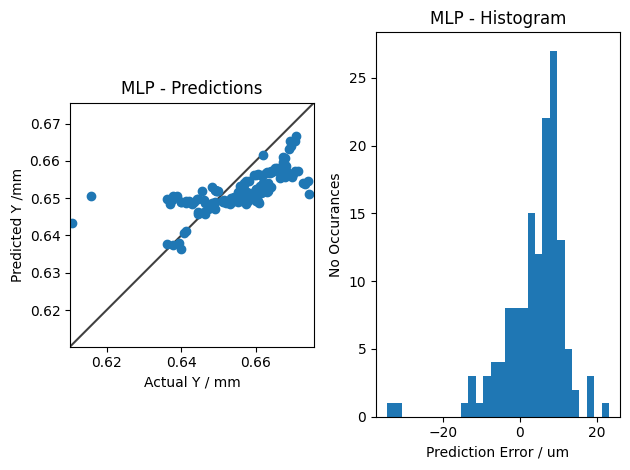

In [18]:
y = mlp_reg.val_data[1].values
y_pred = mlp_reg.model.predict(mlp_reg.val_data[0].values, verbose=0)
pred_plot(y, y_pred, 'MLP')

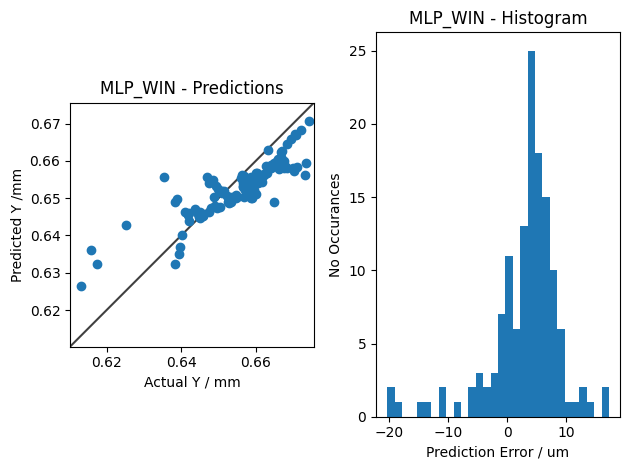

In [19]:
y = mlp_win_reg.val_data[1]
y_pred = mlp_win_reg.model.predict(mlp_win_reg.val_data[0], verbose=0)
pred_plot(y, y_pred, 'MLP_WIN')

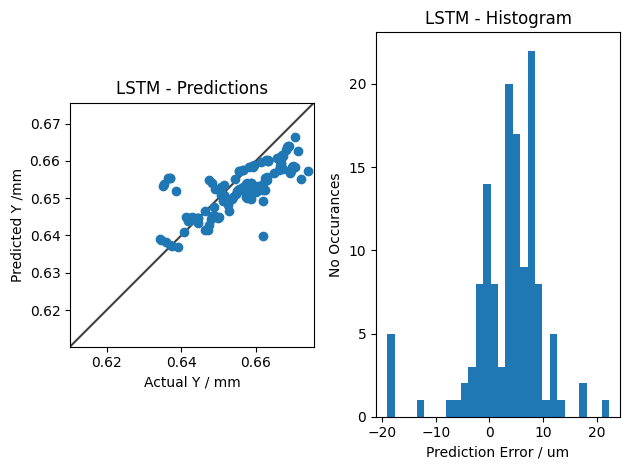

In [20]:
y = lstm_reg.val_data[1]
y_pred = lstm_reg.model.predict(lstm_reg.val_data[0], verbose=0)
pred_plot(y, y_pred, 'LSTM')